For a recap, for a Microsoft course in principles of machine learning the final assessment was to create a linear regression model.

As our final assessment we were provided a data set and were to create a linear regression model that predicted the average monthly spend for an individual at a bike shop.

In the prior notebook I did some exploratory data analysis and data formatting in preparation for the machine learning model. In this notebook the data will undergo a more significant transformation, and be fit to the model. Then, the model will be evaluated on its performance metrics.

In [1]:
# Import all packages
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math

%matplotlib inline

In [2]:
# Read into a dataframe
AdvWorksCust = pd.read_csv('averageMonthlySpendPrepared.csv')
AdvWorksCust.shape

(16404, 15)

We have 16,404 rows and 15 fields. Of those fields, 12 of them are features.  Recall that our label is 'AveMonthSpend', but we took the logarithm of those values to shape our distribution closer to a Normal/Gaussian distribution. Transforming the label to a normal distribution increases predictability.

In [3]:
AdvWorksCust.head(20)

,CustomerID,CountryRegionName,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,AveMonthSpend,BikeBuyer,Age,log_AveMonthSpend
0,11000,Australia,Bachelors,Professional,Male,Married,HomeOwner,zero_two,Zero,Two,137947,89,NotPurchaseBike,53,4.488636
1,11001,Australia,Bachelors,Professional,Male,Single,NotHomeOwner,zero_two,Three,Three,101141,117,PurchaseBike,54,4.762174
2,11002,Australia,Bachelors,Professional,Male,Married,HomeOwner,zero_two,Three,Three,91945,123,NotPurchaseBike,54,4.812184
3,11003,Australia,Bachelors,Professional,Female,Single,NotHomeOwner,zero_two,Zero,Zero,86688,50,NotPurchaseBike,51,3.912023
4,11004,Australia,Bachelors,Professional,Female,Single,HomeOwner,three_four,Five,Five,92771,95,PurchaseBike,51,4.553877
5,11005,Australia,Bachelors,Professional,Male,Single,HomeOwner,zero_two,Zero,Zero,103199,78,PurchaseBike,54,4.356709
6,11006,Australia,Bachelors,Professional,Female,Single,HomeOwner,zero_two,Zero,Zero,84756,54,PurchaseBike,53,3.988984
7,11007,Australia,Bachelors,Professional,Male,Married,HomeOwner,zero_two,Three,Three,109759,130,PurchaseBike,55,4.867534
8,11008,Australia,Bachelors,Professional,Female,Single,HomeOwner,three_four,Four,Four,88005,85,PurchaseBike,55,4.442651
9,11009,Australia,Bachelors,Professional,Male,Single,NotHomeOwner,zero_two,Zero,Zero,106399,74,NotPurchaseBike,55,4.304065


**Preparing for One-Hot Encoding**

One-Hot encoding is a process in which a column and its respective values are transformed into a matrix. This process will be explained below, but each value for the particular column becomes a column in itself, and each record then gets a flag if this column (value) holds true for the record.

This process will be used for categorical features.  Many machine learning algorithms can't operate on text data directly, therefore, input and output variables are to be numeric. This constraint is more a reflection of an algorithm's implementation efficiency and not a limitation of the algorithm itself.

I will start with one column as an example. Examine the column 'CountryRegionName' in the output above. You can see that the first 12 records have 'Australia' as the value, and then the 'United States', and 'Canada' further down the records. Examining the output below: the first line prints out the unique values for the 'CountryRegionName' column. The second output is an enumeration that shows how the encoder fits numeric values to each of the string literals.  The third output shows the numerical values for the first 20 records in the 'CountryRegionName'. You can see how the first 12 records have zeros, representing 'Australia', and subsequent records have their corresponding numerical values - matching the output above.

In [4]:
names = np.sort(AdvWorksCust['CountryRegionName'].unique())
print('Unique values:')
print('{}\n'.format(np.sort(names)))
print('Numeric Mapping:')
print('\n'.join('{}: {}'.format(*k) for k in enumerate (names)))
Features = AdvWorksCust['CountryRegionName']
enc = preprocessing.LabelEncoder()
enc.fit(Features)
Features = enc.transform(Features)
print('\nTop 20 records in the \'CountryRegionName\' column encoded numerically:')
print('{}'.format(Features[:20]))

Unique values:
['Australia' 'Canada' 'France' 'Germany' 'United Kingdom' 'United States']

Numeric Mapping:
0: Australia
1: Canada
2: France
3: Germany
4: United Kingdom
5: United States

Top 20 records in the 'CountryRegionName' column encoded numerically:
[0 0 0 0 0 0 0 0 0 0 0 0 5 5 5 5 5 1 1 5]


**One-Hot Encoding**

Let's take this a step further. Now, let's imagine each unique value in our 'CountryRegionName' is a column header. We are going to have 6 new columns - one for each of our unique values. The records have one of those 'CountryRegionName' values, for the value the record has, it gets a 1 in the respective column, and gets a 0 in all other columns.

The print out below shows our column header names and the first 20 records from our set. Each record is going to have values for 6 columns - a 1 for the value it has (one-hot), and zeros for all other columns. Again, the first 12 records have a 1 in the first column - the 'Australia' column, and then records have 1 for the 'United States' column, and then 'Canada' further down the record list. 

This is One-Hot Encoding. 

As you can imagine, this is going to increase the number of columns that we are going have in our data set.

In [5]:
print(np.sort(AdvWorksCust['CountryRegionName'].unique()))
ohe = preprocessing.OneHotEncoder()
encoded = ohe.fit(Features.reshape(-1,1))
Features = encoded.transform(Features.reshape(-1,1)).toarray()
Features[:20, :]

['Australia' 'Canada' 'France' 'Germany' 'United Kingdom' 'United States']


array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

We are now going to encode all of our categorical columns. Below is a method that we will use in a loop to One-Hot Encode our remaining categorical columns. It is basically the same code as above. We have 10 categorical columns. The 'CountryRegionName' is already encoded. We will encode the remaining 9 columns and concatenate the set to our existing set.

Examining the shape below, 10 columns became 38. One record is printed out - how many 1's should it have?

Ten. One 1 that represents one value for each of our original 10 columns i.e. we have 38 unique values collectively among ten categorical columns and each record can take on one value per our original 10 columns.

In [6]:
def encode_string(categorical_features):
    # encode the strings to numerical features
    enc = preprocessing.LabelEncoder()
    enc.fit(categorical_features)
    enc_categorical_features = enc.transform(categorical_features)
    # apply the one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_categorical_features.reshape(-1,1))
    return encoded.transform(enc_categorical_features.reshape(-1,1)).toarray()

categorical_columns = ['Education', 'Occupation', 'Gender', 'MaritalStatus', 'HomeOwnerFlag', 'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren', 'BikeBuyer']

for column in categorical_columns:
    temp = encode_string(AdvWorksCust[column])
    Features = np.concatenate([Features, temp], axis = 1)

In [7]:
print(Features.shape)
print(Features[:1, :])

(16404, 38)
[[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]]


We will now join our remaining numerical columns with our categorical data set. 

Our data set, now including the numerical features, has 40 columns. Examining the print out of the first row below, you can see the trailing columns have a yearly income of `$`137,947 and an Age of 53 years old. You can check it with the first row of the output at the top of the notebook. 

In [8]:
Features = np.concatenate([Features, np.array(AdvWorksCust[['YearlyIncome', 'Age']])], axis = 1)
print(Features.shape)
print(Features[:1, :])

(16404, 40)
[[1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  1.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00 1.37947e+05 5.30000e+01]]


**Splitting the Data**

Within machine learning, what you put in is what you get out i.e. good data preparation is required to ensure good model performance.

We are going to split our data set and create an independently sampled training dataset and a test data set. Notice the word "sampled" - the data set is split in a random fashion as to not introduce bias. The random sub-samples of the data are created using a process called Bernoulli sampling. Bernoulli sampling is that the probability that a given case is accepted in the training data set is p, and the probability that the case is in the test dataset is 1 - p.

If the same data is used to train and test the machine learning model, the model will simply be learning the training data. The results of the model will likely be great with the training data set and give unpredictable results with new cases. Here is a trivial example just to make the point, suppose I only train the model with young individuals who have a large yearly income, it's likely that the model will give good results for data sets who have large earning young individuals and perform precariously for data sets that don't share these similarities.

We could say the model is 'overfit' to young individuals with large incomes, and will not "generalize" well. A model that generalizes well will produce consistent results when presented with new, never encountered cases.

The train_test_split function below performs Bernoulli sampling. It samples the index for the array containing the features and label values. The data set will be split into 80% training data and 20% testing data.

In [9]:
# randomly sample cases to create independent training and test data
nr.seed(9383)

labels = np.array(AdvWorksCust['log_AveMonthSpend'])
# .shape gives the rows and columns count, specifying an argument/index returns the row or column count
index = range(Features.shape[0])
index = ms.train_test_split(index, test_size = 0.2)

# split the test and train data into features and labels
x_train = Features[index[0], :]
y_train = np.ravel(labels[index[0]])
x_test = Features[index[1], :]
y_test = np.ravel(labels[index[1]])

**Rescaling**

We will now rescale features. Rescaling of numeric features is important because we don't want the magnitude (numeric range) of a feature to determine how much "weight" that feature holds in determining the training of the maching learning model.

For example, consider a data set with the feature age, in years measured by tens, and a feature income, measured in tens of thousands. We would not want the model to reflect that income is more important simply because the magnitude of the numbers are larger. To prevent this, numeric features are scaled, or 'normalized', to the same range.

There are many scaling methods out there: Min-Max normalization, Mean Normalization, Z-Score normalization, and Unit Vector Normalization. I will be using Z-Score normalization so that variables have zero mean and unit standard deviation.

The standard scaler function calculates the scaling coefficients for the training data. Notice that the scaling function calculations are performed only on the training data and not the test data. This transformation is then applied to the training and test data using the transform method.

Generally, a label is of the numeric type does not need to be scaled. Other transformations can occur, such as how the log function was applied to our label here.

The numerical values for the first couple records have been printed below. One way to describe a Z-Score is the number of standard deviations away from the mean. Most of the values displayed below are approximately 1 standard deviation less than the mean. The Age of the first record has a Z-Score of -0.20, this could be described as a value slightly below the Mean of the Age values.

Also, if you look at the number of records for the test data in the shape printout, there are 13,123 records. This is 13,123/16,404 = 0.799988, which is approximately 80%, the value of the 80/20 split.

In [10]:
# Compute the mean and std to be used for later scaling
scaler = preprocessing.StandardScaler().fit(x_train[:, 38:])

# scale the training and test data
x_train[:, 38:] = scaler.transform(x_train[:, 38:])
x_test[:, 38:] = scaler.transform(x_test[:, 38:])

print(x_train.shape)
x_train[:2, 38:40]

(13123, 40)


array([[-0.97691127, -0.20706381],
       [-0.81952703, -1.09733913]])

In [11]:
# define and fit the linear regression model from scikit learn
lin_regr_model = linear_model.LinearRegression(fit_intercept = False)
lin_regr_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [12]:
print(lin_regr_model.intercept_)
print(lin_regr_model.coef_)

0.0
[ 2.07307378e-01  2.14847565e-01  2.24072605e-01  2.19028109e-01
  2.17790735e-01  2.11328615e-01  9.52464187e+10  9.52464187e+10
  9.52464187e+10  9.52464187e+10  9.52464187e+10 -1.06246063e+10
 -1.06246063e+10 -1.06246063e+10 -1.06246063e+10 -1.06246063e+10
 -2.51318797e+10 -2.51318797e+10 -1.11298750e+10 -1.11298750e+10
 -2.06108291e+10 -2.06108291e+10 -7.80043098e+09 -7.80043098e+09
 -4.81965156e+09 -4.81965156e+09 -4.81965156e+09 -4.81965156e+09
 -4.81965156e+09 -4.81965156e+09 -2.45330808e+08 -2.45330808e+08
 -2.45330808e+08 -2.45330808e+08 -2.45330808e+08 -2.45330808e+08
 -1.48838153e+10 -1.48838153e+10  9.80600666e-02 -3.27532452e-02]


**Evaluation of Performance Metrics**

We are now going to evaluate the regression model. Our evaluation will be done through examining specific performance metrics - much of these metrics are used in academic models across the sciences. Let's take a brief examination of these metrics.

Our model is trying to predict the logarithm of the Average Monthly Spend. In doing so, there is error in the prediction. The lower the error the better the prediction. We are going to examine different statistics relating to our model's error. 

Mean Square Error (MSE) and Root Mean Square Error (RMSE) - MSE is the average squared difference between the predicted values and the actual values. The RMSE is the square root of the MSE. These are called absolute measures of error in the model. The error values have the same units as the label. As opposed to relative metrics, where error results would always be a value between 0 and 1.

Mean Absolute Error (MAE) and Median Absolute Error - MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average of the absolute value of the differences between the predicted values and the actual values. The Median Absolute Error takes the median of the absolute differences in the values.

There is much discussion between RMSE and MAE. From a mathematical perspective, the absolute value is a linear function and the squared function, or quadratic, is non-linear. This means that the quadratic is much more sensitive to differences, if they exist. 

For example, suppose the difference in your predicted value and actual value is -2. The absolute value of -2 equals 2, and -2 squared equals 4. Now, suppose the difference is -4. The absolute value of -4 equals 4, and -4 squared equals 16. For the quadratic function, the jump from 2 to 4 is slightly amplified, but the jump from 4 to 16 is much more amplified. The absolute value differences didn't "jump" at all (just became positive). Hence, the quadratic is much more sensitive differences - it seems the larger the difference, the larger the quadratic result.

But wait, suppose the difference between the predicted value and absolute value is 1/4. The value of 1/4 squared is 1/16. The value of 1/16 is smaller than the value of 1/4. The jump from 1/4 to 1/16 is definitely not amplified. No, it's not, in fact it's the opposite, it's tempered or blunted. The quadratic mitigated the magnitude of the difference, if the difference was less than 1. That's why I chose the language, "sensitive to differences". It doesn't neccessarily amplify differences. Note: I chose some negative differences so that you notice both RMSE and MAE are always positive, regardless of direction.

The $R^2$ metric is also known as the Coefficient of Determination - $R^2$ indicates the proportion of the variance in the labels and the input variables or parameters. That is, the proportion of variance in the model that can be explained by the variables within the model itself. In general, a high $R^2$ value indicates the model is a good fit for the data. Although, a high value and fit depends on the context of analysis. The range of $R^2$ values is between 0 and 1 (although, there are exceptions). Depending on your model, 0.30 may be a very high portion of the variation in the model to predict, whereas, in extremely technical sciences, the expectation is more near a value of 1.

If the number of parameters is significant with respect to the number of records, $R^2$ will give an overly optimistic measure of model performance. In general, the difference between Adjusted $R^2$ and $R^2$ becomes less significant as the number of records increases. To help account for this overly optimistic effect, the Adjusted $R^2$ takes into account the number of parameters in the model. The Adjusted $R^2$ increases only if the increase in $R^2$ is greater than one would expect from chance alone. If the model has a large number of parameters compared to the number of records, and the $R^2$ is rather different from the Adjusted $R^2$, then this may indicate that the model may be overfit and might not generalize well.

Examining all the metrics holistically provides the best evaluation of the model.  Although, some metrics may be more valuable to your model than others. Suppose your model is in the medical field and you are highly concerned of any error because a life is at stake. Then the RMSE may be a valuable metric for that model.

The metrics below seem promising. The RMSE and MAE are small and in a relative range of one-another. The Median Absolute Error is slightly smaller than the Mean Absolute Error indicating that there are some outliers that exist in the set. The $R^2$ and Adjusted $R^2$ are high and close to one-another, indicating the model will probably generalize well.

In [13]:
def print_metrics(y_true, y_predicted, n_parameters):
    # compute R^2 and subsequently adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1) / (y_true.shape[0] - n_parameters) * (1 - r2)
    
    # print R^2 values and metrics
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))

y_score = lin_regr_model.predict(x_test)

# confirm n_parameters is the # of features
print_metrics(y_test, y_score, 40)

Mean Square Error      = 0.0037854525802458266
Root Mean Square Error = 0.061526031728414164
Mean Absolute Error    = 0.04598751545314666
Median Absolute Error  = 0.03644659140799078
R^2                    = 0.9677157753187328
Adjusted R^2           = 0.9673272888137746


**Residuals**

Residuals are simply the difference between the predicted values and the actual values - the error. We would like the residuals to be as close to zero as possible.

Below is histogram of the error for our data points. We would expect to see most of the errors centered around zero in a relatively Normal distribution. That is exactly what we see below. As the value of the residuals gets further from zero, the count of these values decreases in a smooth fashion. But, notice the tail on the left-side of the distribution - there are our outliers.

Suppose it wasn't decreasing smoothly centered around zero. Suppose you had three humps. A hump at -0.1, a dip, a hump at 0.0, a dip, and a hump at 0.2. Your model is creating a significant amount of errors at -0.1, 0.0, and 0.2. There is a pattern to the values of the model's errors. Then, more investigation would need to take place. What is common to all the points at -0.1? 0.0? 0.2? Maybe we are using the wrong model? Maybe there are three models? The cause would need to be examined and those factors taken into consideration for the model.

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


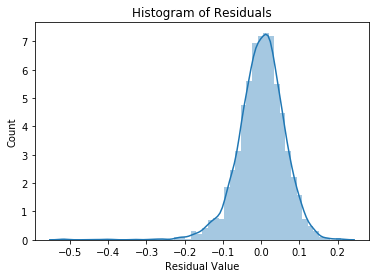

In [14]:
def histogram_residuals(y_test, y_score):
    # compute vector of residuals
    residuals = np.subtract(y_test.reshape(-1, 1), y_score.reshape(-1, 1))
    
    # make the residual histogram
    sns.distplot(residuals)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residual Value')
    plt.ylabel('Count')
    
histogram_residuals(y_test, y_score)

**Quantile-Quantile Normal Plot (Q-Q Normal Plot)**

This plot displays quantiles of a standard Normal distribution on the horizontal axis and the quantiles of the residuals on the vertical axis. What does that mean - the red line are the points for a perfect Normal Distribution. The blue points are the points for our residuals. If the residuals were perfectly Normally distributed, these points would fall exactly on that straight line. In real-world application problems, you should expect the straight line relationship to be approximate.

Here, the outliers are readily apparent. Showing that tail dropping off - displaying some slight left-skew. Other than that, our residuals map to that straight line really well.

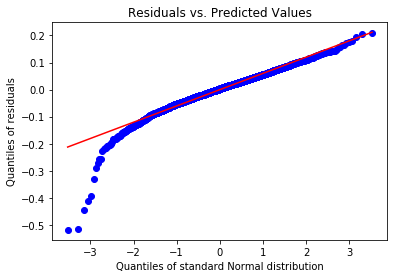

In [15]:
def residual_qq(y_test, y_score):
    # compute the vector of residuals
    residuals = np.subtract(y_test.reshape(-1, 1), y_score.reshape(-1, 1))
    
    #make the residual plot
    ss.probplot(residuals.flatten(), plot = plt)
    plt.title('Residuals vs. Predicted Values')
    plt.xlabel('Quantiles of standard Normal distribution')
    plt.ylabel('Quantiles of residuals')
    
residual_qq(y_test, y_score)

**Residual Plot**

A Residual plot is a plot of residuals vs. predicted values (scores) and shows if there is structure in the residuals. For an ideal Regression Model the dispersion of the points of the residuals should not change with the values of the predicted values. You should not see any correlation between the predicted values and the residuals. It has been said that the ideal residual plot should look like a 'fuzzy caterpillar' with no change vs. the predicted value. 

Let me expound on this, say, as your predicted values increase your residuals increase i.e. as your predicted values increase your error is increasing. Your model has small errors for small values and large errors for large values. The magnitude of the predicted values is indicative of how much error it has - that is a bad model. We want as little error as possible, and if we have it, it should be dispersed evenly over the set - error values should not be dependent on predicted values.

Our plot does display uniform dispersion across the predicted values. You can see the outliers at the lower end of the predicted values. Our errors do tighten up as the predicted values increase, but there is still much uniformity throughout the higher predicted values. What we don't want are any direct or inverse relationship among the predicted values and residuals - we don't want significant slope in our caterpillar here.

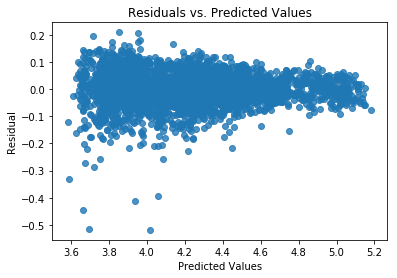

In [16]:
def residual_plot(y_test, y_score):
    # compute the vector of residuals
    residuals = np.subtract(y_test.reshape(-1, 1), y_score.reshape(-1, 1))
    # make the residual plot
    sns.regplot(y_score, residuals, fit_reg = False)
    plt.title('Residuals vs. Predicted Values')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residual')
    
residual_plot(y_test, y_score)

But, wait...what is our predicted values here? We have predicted the logarithm of the Average Monthly Spend. We have transformed the label using the log function. We have to reverse that transformation using the the inverse function of the logarithm i.e. the exponential function. The exponential transformation of the logarithm will yield the exact predictions for the Average Monthly Spend. This will be the caterpillar that matters.

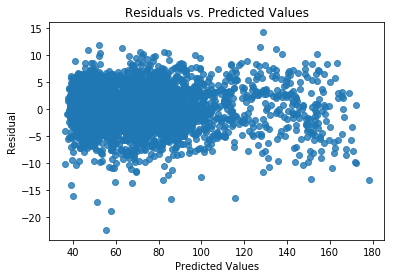

In [17]:
y_score_untransform = np.exp(y_score)
y_test_untransform = np.exp(y_test)
residual_plot(y_test_untransform, y_score_untransform)

Nice! We do have a nice looking caterpillar here. It is more dense from about `$`40-`$`85. That would make sense - it would be logical that majority of people fall within a range of money spent at a bike shop. Then, you have the big spenders, where our points begin to thin out. You notice our outliers, in particular those in the negative - starting at about -13 down to around -23. 

But, most importantly, other than the pure number of points, there is a nice even dispersion as predicted values change. We don't see an extreme increasing or decreasing slope, or the points don't blow up, randomly distributed all over the plot.

This is again, a model that seems promising. As it stands, it appears this model would display favorable generalization. 